<a href="https://colab.research.google.com/github/Hoangthang017/CS114.K21/blob/master/FaceMask_ML/FaceMask_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Xây dựng model**

##**Mount drive**

In [200]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Các thư viện được sử dụng trong bài**

In [201]:
# import các thư viện cần dùng

# các thư viện dùng để load và xử lí dữ liệu
from imutils import paths
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dùng để tăng dữ liệu trên dữ liệu đã có sẵn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tiến hành chia dữ liệu
from sklearn.model_selection import train_test_split

# Các model 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Đánh giá các model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##**Load data từ Google Drive và tiền xử lí nó**

###**Lấy đường dẫn file chưa data và khởi tạo 2 list data và label**

- Dùng hàm list_images của thư viện paths để lấy tất cả link của ảnh chứa trong folder 
- Biến Mask  và Without_mask dùng để đếm số lượng từng loại trong dataset

In [202]:
# load dataset 
print(" loading images...")

# lấy link ảnh có khẩu trang và không có khẩu trang
imagePaths_Mask = list(paths.list_images('/content/drive/My Drive/CS114/FaceMask/FaceMask_MachineLearning/Datasets/Mask/with_mask'))
imagePaths_No_Mask =  list(paths.list_images('/content/drive/My Drive/CS114/FaceMask/FaceMask_MachineLearning/Datasets/Without_Mask/Without_mask'))

# hợp nhất 2 link vào 1 file
imagePaths = imagePaths_Mask + imagePaths_No_Mask

# khởi tạo dữ liệu
data = []

# khởi tạo label ứng với dữ liệu
labels = []

 loading images...


##**Load từng ảnh từ file và preprocess nó**
- Load hình ảnh từ link đã lấy được 
- Sử dụng ImageDataGenerator để tăng số ảnh (2 ảnh)
- Ở mỗi ảnh được tạo ra : 
  - Tiến hành resize ảnh về 32x32 nhằm giảm số lượng feature cho model 
  - Biến đổi ảnh này từ mảng 3 chiều thành 1 vector bằng hàm flatten của 32x32 thư viện numpy
  - ứng với mỗi giá trị trong vector sẽ là 1 feature trong model

###**Fine-turning hàm ImageDataGenerator**
- rotation_range : góc quay ( 0 - 20 )
- zoom_range : độ phóng  (0 - 0.15)
- width_shift_range, height_shift_range : độ dịch ảnh (0 - 0.2)
- horizontal_flip : lật ảnh theo chiều ngang

In [203]:
# Sử dụng kỹ thuật Data Augmentation để tăng kích thước cho bộ train data
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	horizontal_flip=True )

###**Hàm load ảnh và tiền xử lí ảnh**
- Tiến hành chia đường dẫn ra thành các ký tự và lấy nhãn ra 
- Đọc hình ảnh từ link
- Tăng số chiều cho ảnh vừa đọc để phù hợp với input của hàm ImageDataGenerator
- Dùng hàm flow của ImageDataGenerator để tiến hành tăng dữ liệu 
- Ở bài này với mỗi ảnh được load sẽ được tăng thành 2 ảnh khác nhau :
  - Giảm chiều ảnh được tăng 
  - resize các ảnh được tăng về 32 x 32 
  - Làm phẳng ảnh thành vector
- Đẩy label và ảnh vào data và labels


In [204]:
# Vòng lặp để load dữ liệu 

for imagePath in imagePaths:
	# lấy nhãn từ đường dẫn tệp
	label = imagePath.split("/")[-2]
	
	# load hình ảnh 
	image = cv2.imread(imagePath)
	
	# Tăng số chiều cho ảnh , để phù hợp với hàm ImageDataGenerator
	image = np.expand_dims(image, axis=0)
	
	# Sử dụng hàm flow để tăng dữ liệu
	augImage = aug.flow(image)	
 
	# Đổi label sang dạng số 
	if (label == "with_mask"):
		label = 1
	else:
		label = 0

	# Sử dụng hàm ImageDataGenerator để tăng 2 ảnh tương ứng với mỗi ảnh 
	i = 1
	for img  in augImage:
		# giảm chiều đã tăng , resize ảnh về (32,32) và làm phẳng ảnh 
		img = cv2.resize(img[0],(32,32)).flatten()
	 
	 	# đẩy dữ liệu vào data và labels
		data.append(img)
		labels.append(label)

		# Tăng 2 ảnh 
		if (i == 2):
			i = 1
			break
		i += 1


##**Chuyển data và label sang dạng mảng**

In [205]:
# chuyển label và data sang dạng mảng 
labels = np.array(labels)
data = np.array(data)

print(data)
print(data.shape)

[[ 89.        83.       100.       ...  51.        48.        50.      ]
 [ 66.35162   62.35163   74.35162  ...  59.        45.79605   47.79605 ]
 [ 87.75025  127.0006   202.0009   ... 133.04822  125.43568  151.20032 ]
 ...
 [118.205795 138.50725  185.42613  ...  33.969776  33.122807  54.7139  ]
 [ 88.09506  104.858765 134.62248  ... 107.62648  110.64119  189.84006 ]
 [112.77849  132.10146  159.07956  ...  38.130226  32.55661  138.71698 ]]
(2068, 3072)


##**Biểu đồ thể hiện số lượng data**

1050


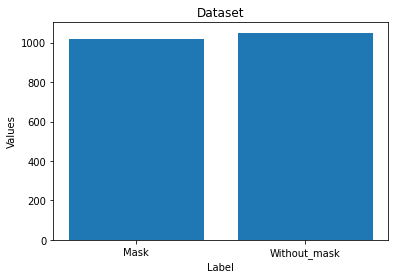

In [206]:
# Đếm số lượng label có trong dataset
Without_mask = data[labels == 0].shape[0]
Mask =  data[labels == 1].shape[0]

print(Without_mask)
# Biểu đồ thể hiện số lượng data 
Label = ["Mask","Without_mask"]
Values = [Mask,Without_mask]

plt.bar(Label,Values)
plt.title("Dataset")
plt.xlabel("Label")
plt.ylabel("Values")

plt.show()

##**Chia dữ liệu thành 2 phần train và test**
- Chia data thành 2 phần nhằm đánh giá model 
- 80 % : dùng để train và validation qua phương pháp k-fold
- 20 % : để đánh giá lại model đã chọn được sau khi sử dụng k-fold


In [207]:
# chia đữ liệu thành 80% để train, validation bằng K-Fold và 20% để test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,stratify=labels,random_state=1)

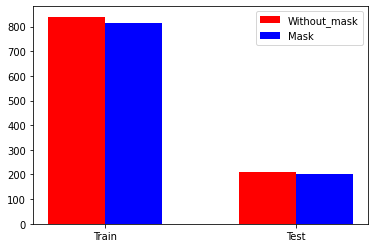

In [208]:
# Đếm các nhãn trong tập train
Without_mask_train = trainX[trainY == 0].shape[0]
Mask_train =  trainX[trainY == 1].shape[0]

# Đếm các nhãn trong tập test
Without_mask_test = testX[testY == 0].shape[0]
Mask_test =testX[testY == 1].shape[0]

# Biểu đồ thể hiện số lượng data 
Label = ["Train","Test"]
Values_without_mask = [Without_mask_train,Without_mask_test]
Values_mask = [Mask_train,Mask_test]

index = np.arange(2)
width = 0.3

plt.bar(index,Values_without_mask,width,color = 'red',label = 'Without_mask')
plt.bar(index+width , Values_mask, width, color = 'blue', label = "Mask")

plt.xticks(index + width/2 , Label)
plt.legend()
plt.show()


##**Training và đánh giá model**
- Chọn model thuộc Binary Classification bởi vì label có dạng 0 và 1 
- Các model Binary Classification được sử dụng trong bài :
  -  Decision Tree
  - Random Forest
  - Logictic Regression
- Do dataset khá ít (2000 ảnh), vì thế sử dụng phương pháp Cross-validation để đánh giá các model được chọn . Cụ thể trong bài toán này sử dụng K - Fold
- Chọn ra model có accuracy cao nhất sau khi sử dụng K-Fold
- Tiến hành training và đánh giá model này thông qua hàm confusion_matrix và classification_report của thư viện sklearn


###**Khởi tạo các model được chọn**

In [209]:
# khởi tạo các model được dùng 
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF',RandomForestClassifier()))

###**Sử dụng K-Fold để đánh giá model**
- K-Fold là phương pháp chia bộ dữ liệu thành K phần
- Sẽ có K lần train
- Trong mỗi lần train , 1 phần sẽ được dùng để đánh giá và K - 1 phần còn lại dùng để train
- Cụ thể bài toán sử dụng 10 - Fold
- Fine-turning cho hàm StratifiedKFold :
  - n_splits=10 : chia tập train thành 10 phần
  - random_state=1 : chọn ngẫu nhiên để chia vào các phần
  - shuffle=True : xáo trộn tập train trước khi chia
- Fine-turning cho cross_val_score :
  - model, trainX, trainY : đưa vào model cộng tập dữ liệu 
  - cv=kfold : chọn phương pháp k-fold
  - scoring = 'accuracy' : chọn score là độ chính xác của model

In [210]:
# Sử dụng hàm StratifiedKFold của sklearn để train và test model 
results = []
names = []

# Vòng lặp để tiến hành train và validation cho mỗi model
for name,model in models:

  # Fine-turning cho hàm StratifiedKFold
  kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

  # Đánh giá model bằng phương pháp cross-validation
  cv_results = cross_val_score(model, trainX, trainY, cv=kfold, scoring='accuracy')

  # đẩy kết quả vào results
  results.append(cv_results)
  names.append(name)

  # Xuất ra giá trị trung bình của results 
  print('%s: %f ' % (name, cv_results.mean()))

LR: 0.850628 
DT: 0.813782 
RF: 0.906261 


###**Biểu đồ đánh giá kết quả**
- Dễ dàng quan sát các các giá trị result của mỗi lần train trong K-Fold

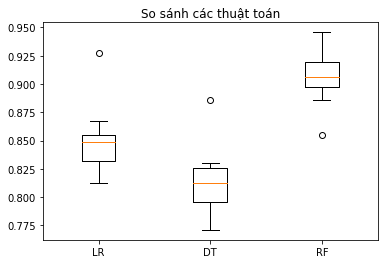

In [211]:
# Biểu đồ xem xét kết quả sau khi dùng K-Fold
pyplot.boxplot(results, labels=names)
pyplot.title('So sánh các thuật toán')
pyplot.show()

###**Đánh giá model Random Forest**
- Accuracy của model Random Forest khá cao
- Như kết quả ta có thể thấy accuracy trên tập test và tập train không chênh lệch nhau quá nhiều vì thế model có thể chấp nhận được
- Ở ma trận nhầm lẫn :
  - Model đều dự đoán khá chính xác ở cả 2 nhãn
  - Model dự đoán False Positive cao hơn False Negative ở bài này là chấp nhận được vì thà dự đoán nhầm 1 người đeo khẩu trang thành không đeo còn hơn dự đoán sai một người không đeo khẩu trang thành có đeo sẽ gây ra thiệt hại cao hơn

In [212]:
# Chọn RandomForest làm model để đánh giá trên tập test
model = RandomForestClassifier()
model.fit(trainX, trainY)
predictions = model.predict(testX)

# Đánh giá model
print(confusion_matrix(testY, predictions))
print(classification_report(testY, predictions))

[[200  10]
 [ 30 174]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       210
           1       0.95      0.85      0.90       204

    accuracy                           0.90       414
   macro avg       0.91      0.90      0.90       414
weighted avg       0.91      0.90      0.90       414



##**Save Model**
- Lưu model để thuận tiện cho việc sử dụng

In [214]:
import pickle
f = open('/content/drive/My Drive/CS114/FaceMask/FaceMask_MachineLearning/Model/Model_FaceMask.pkl', 'wb')
pickle.dump(model, f)

##**Link tham khảo**
- https://towardsdatascience.com/classifying-cat-pics-with-a-logistic-regression-model-e35dfb9159bb
- https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html
- https://scikit-learn.org/stable/modules/cross_validation.html
